In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import operator
import seaborn as sns
from scipy.stats import ttest_1samp, ttest_ind
from collections import Counter, defaultdict
import math
import sys
sys.path.append('..')
from helpers.funcs import *

In [2]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
cluster_names = {v:k for k, v in config['CLUSTER_NAMES'].items()}

In [3]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [4]:
def split_party(part_tweets):
    return part_tweets[part_tweets['dem_follows'] > part_tweets['rep_follows']], part_tweets[part_tweets['dem_follows'] < part_tweets['rep_follows']]

In [5]:
def get_odds(tweets,  search):
    total = len(tweets)
    contains = tweets['text'].str.contains(search, case=False).sum()
    return (contains + 1) / ((total - contains) + 1)

In [13]:
modal_list = []
log_odds_list = []
race = []

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data = filter_retweets(data)
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    modal_list.append('MUST')
    log_odds_list.append(np.log(get_odds(rep, r"\bmust[n'’]?\w*\b") / get_odds(dem, r"\bmust[n'’]?\w*\b")))
    race.append(shooter_race[event])
    modal_list.append('SHOULD')
    log_odds_list.append(np.log(get_odds(rep, r"\bshould[n'’]?\w*\b") / get_odds(dem, r"\bshould[n'’]?\w*\b")))
    race.append(shooter_race[event])
    modal_list.append('NEED TO')
    log_odds_list.append(np.log(get_odds(rep, r"\bneed to\b|\bneeds to\b") / get_odds(dem, r"\bneed to\b|\bneeds to\b")))
    race.append(shooter_race[event])    
    modal_list.append('HAVE TO')
    log_odds_list.append(np.log(get_odds(rep, r"\bhas to\b|\bhave to\b") / get_odds(dem, r"\bhas to\b|\bhave to\b")))
    race.append(shooter_race[event])
    

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [14]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'log_odds':log_odds_list, 'race':race})

In [15]:
for i, g in df.groupby('modal'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

HAVE TO
Ttest_1sampResult(statistic=-6.608889419465189, pvalue=1.9483181505360368e-06)
MUST
Ttest_1sampResult(statistic=-4.203676418304983, pvalue=0.00043694623689948805)
NEED TO
Ttest_1sampResult(statistic=-3.033095955178946, pvalue=0.0065672893980417086)
SHOULD
Ttest_1sampResult(statistic=-3.0886248018459046, pvalue=0.005792319868196137)


In [16]:
for i, g in df.groupby('modal'):
    print(i)
    print(np.mean(np.array(g[g['race']=='white'].log_odds)))
    print(np.mean(np.array(g[g['race']=='POC'].log_odds)))
    print(ttest_ind(np.array(g[g['race']=='white'].log_odds), np.array(g[g['race']=='POC'].log_odds)))

HAVE TO
-0.4693199862542427
-0.2934380446273865
Ttest_indResult(statistic=-1.5585228589745972, pvalue=0.13561062140526003)
MUST
-0.25018281827620564
-0.30580190879543034
Ttest_indResult(statistic=0.413214577707164, pvalue=0.6840756124210534)
NEED TO
-0.1495078887393656
-0.20879674203541237
Ttest_indResult(statistic=0.49567984707856083, pvalue=0.625804914721529)
SHOULD
-0.3082658293749805
-0.04833108713173584
Ttest_indResult(statistic=-2.4238580426013834, pvalue=0.025505278013628254)


In [8]:
df.groupby('modal').median().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.392316
MUST,-0.209859
SHOULD,-0.161042
NEED TO,-0.128364


In [9]:
df.groupby('modal').mean().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.385567
MUST,-0.276668
SHOULD,-0.184487
NEED TO,-0.177741


[None, None]

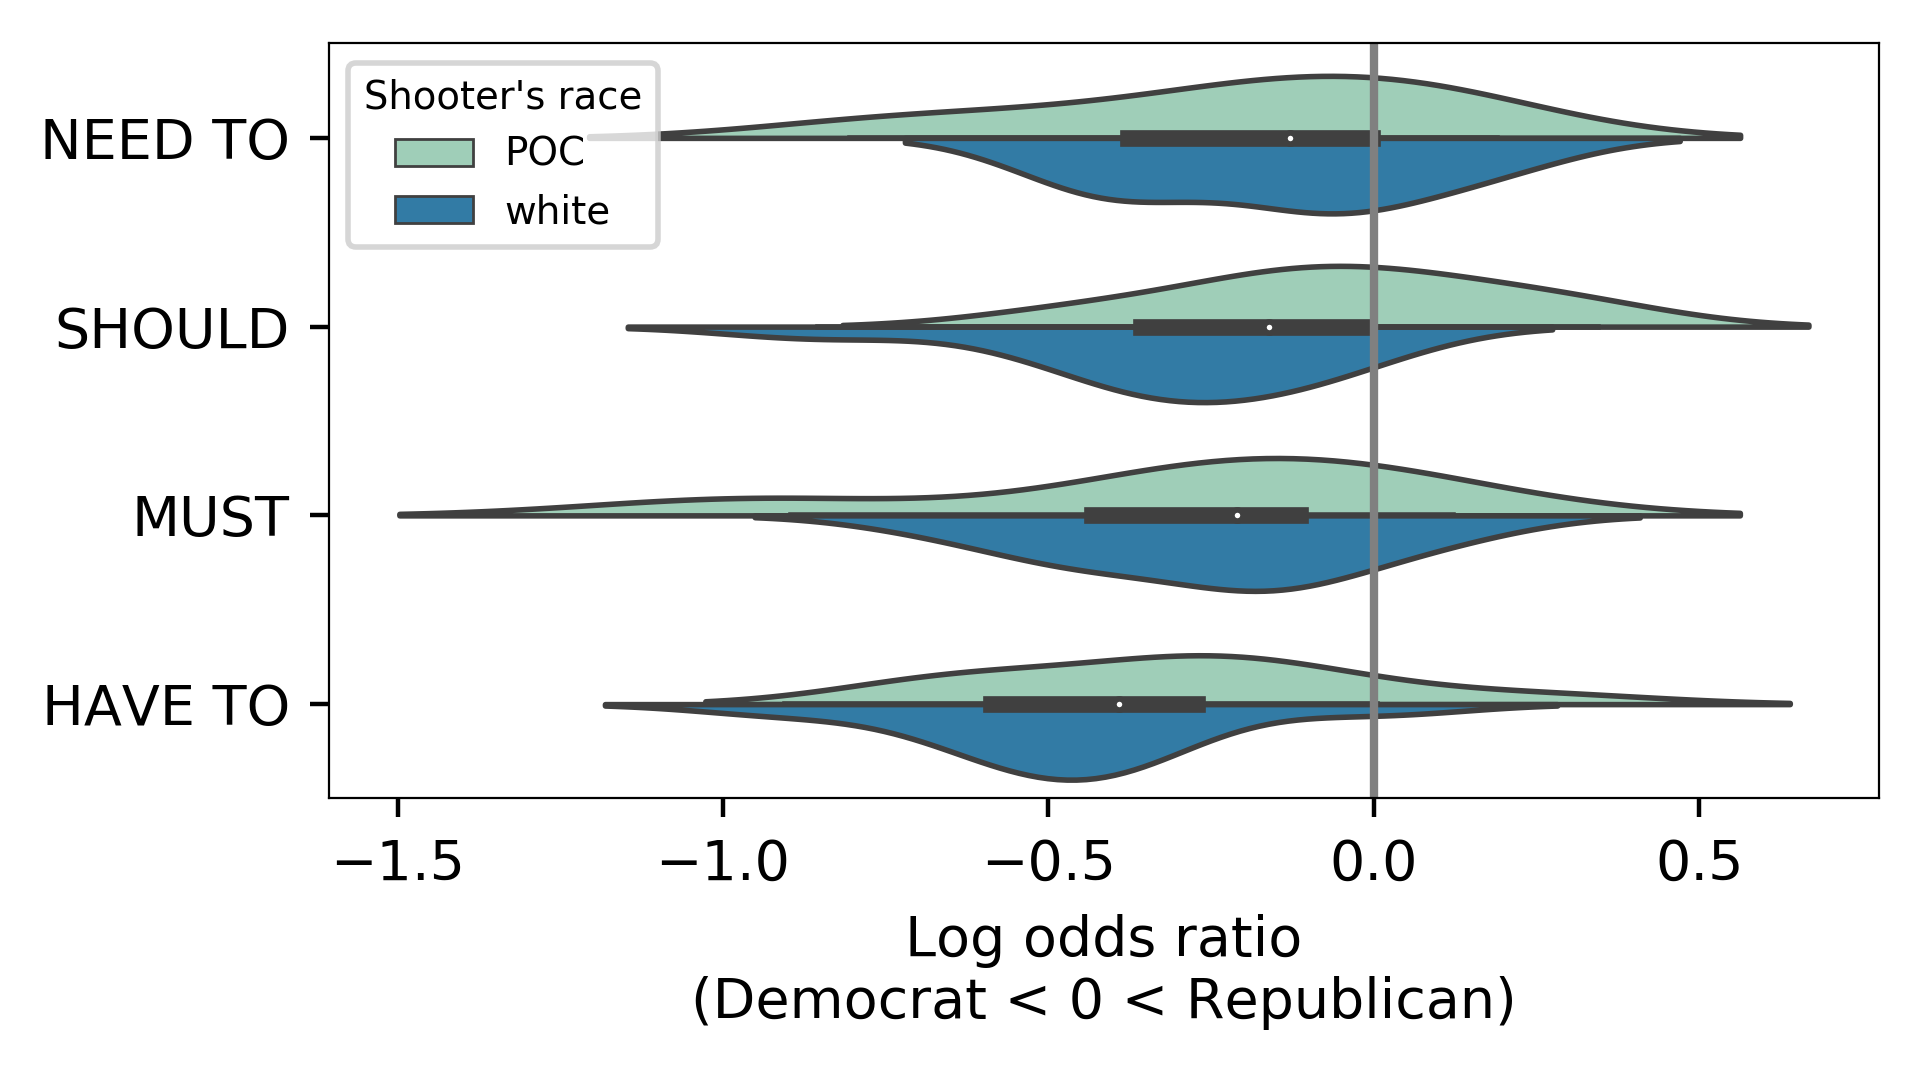

In [10]:
f = plt.figure(dpi=400, figsize=(5,2.5))
ax = sns.violinplot(data=df, x="log_odds",y="modal", hue='race', fliersize=1, linewidth=1, split=True, order=reversed(df.groupby('modal').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.axvline(x=0, color='grey')
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
legend = ax.legend(loc='upper left', title="Shooter's race", fontsize=7)
plt.setp(legend.get_title(),fontsize='x-small')

# distribution of modals across topics

In [16]:
modal_list = []
topic_list = []
value_list = []
event_list = []

def print_distr(event, name, s, total_props):
    print(name)
    b = np.bincount(s['topic'])
    vals = (b / np.sum(b)) / total_props
    #print(((b / np.sum(b)) / total_props))
    for i in range(NUM_CLUSTERS):
        topic_list.append(cluster_names[i])
        value_list.append(vals[i])
        modal_list.append(name)
        event_list.append(event)
        

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                       usecols=['user_id', 'text'])
    data = get_cluster_assignments(event, data, 'relative')
    total_props = np.bincount(data['topic']) / np.sum(np.bincount(data['topic']))

    s = data[data['text'].str.contains(r"\bmust[n'’]?\w*\b", case=False)]
    try:
        print_distr(event, 'MUST', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(r"\bshould[n'’]?\w*\b", case=False)]
    try:
        print_distr(event, 'SHOULD', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(r"\bneed to\b|\bneeds to\b", case=False)]
    try:
        print_distr(event, 'NEED TO', s, total_props)
    except:
        pass
    s = data[data['text'].str.contains(r"\bhas to\b|\bhave to\b", case=False)]
    try:
        print_distr(event, 'HAS TO', s, total_props)
    except:
        pass
    
    #s = data[data['text'].str.contains(r"\bcan[n'’]?\w*\b", case=False)]
    #try:
    #    print_distr(event, 'CAN', s, total_props)
    #except:
    #    pass

chattanooga
MUST
SHOULD
NEED TO
HAS TO
roseburg
MUST
SHOULD
NEED TO
HAS TO
colorado_springs
MUST
SHOULD
NEED TO
HAS TO
san_bernardino
MUST
SHOULD
NEED TO
HAS TO
kalamazoo
MUST
SHOULD
NEED TO
HAS TO
orlando
MUST
SHOULD
NEED TO
HAS TO
dallas
MUST
SHOULD
NEED TO
HAS TO
baton_rouge
MUST
SHOULD
NEED TO
HAS TO
burlington
MUST
SHOULD
NEED TO
HAS TO
fort_lauderdale
MUST
SHOULD
NEED TO
HAS TO
fresno
MUST
SHOULD
NEED TO
HAS TO
san_francisco
MUST
SHOULD
NEED TO
HAS TO
vegas
MUST
SHOULD
NEED TO
HAS TO
thornton
MUST
SHOULD
NEED TO
HAS TO
sutherland_springs
MUST
SHOULD
NEED TO
HAS TO
parkland
MUST
SHOULD
NEED TO
HAS TO
nashville
MUST
SHOULD
NEED TO
HAS TO
santa_fe
MUST
SHOULD
NEED TO
HAS TO
annapolis
MUST
SHOULD
NEED TO
HAS TO
pittsburgh
MUST
SHOULD
NEED TO
HAS TO
thousand_oaks
MUST
SHOULD
NEED TO
HAS TO


In [18]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'proportion':value_list, 'topic':topic_list, 'event':event_list})

In [19]:
df.to_csv(OUTPUT_DIR + 'modal_distributions.csv')

In [20]:
df

,modal,proportion,topic,event
0,MUST,1.279851,shooter's identity\n& ideology,chattanooga
1,MUST,0.538147,news,chattanooga
2,MUST,0.000000,victims & location,chattanooga
3,MUST,2.323887,laws & policy,chattanooga
4,MUST,0.968246,investigation,chattanooga
5,MUST,0.756667,solidarity,chattanooga
6,MUST,0.559113,remembrance,chattanooga
7,MUST,0.664835,other,chattanooga
8,SHOULD,0.705059,shooter's identity\n& ideology,chattanooga
9,SHOULD,0.142320,news,chattanooga


# modality & tense

In [23]:
shouldve_odds = []
not_shouldve_odds = []
prop_shouldve = []
should_odds = []
race = []


for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data = filter_retweets(data)
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    search_shouldve = r"\bshould['’]ve\b|\bshould( not)? have\b|\bshouldn['’]t have\b"
    search_not_shouldve = r"\bshouldn['’]t(?! have)\b|\bshould\b[^'’](?!have)"
    search_all_should = r"\bshould[n'’]?\w*\b"
    shouldve_odds.append(np.log(get_odds(rep, search_shouldve) / get_odds(dem, search_shouldve)))
    not_shouldve_odds.append(np.log(get_odds(rep, search_not_shouldve) / get_odds(dem, search_not_shouldve)))
    should_odds.append(np.log(get_odds(rep, search_all_should) / get_odds(dem, search_all_should)))
    prop = data['text'].str.contains(search, case=False).sum() / data['text'].str.contains(r"\bshould[n'’]?\w*\b", case=False).sum()
    prop_shouldve.append(prop)
    race.append(shooter_race[event])

chattanooga


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


roseburg


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


colorado_springs


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


san_bernardino


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


kalamazoo
orlando


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has ma

dallas


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


baton_rouge


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


burlington
fort_lauderdale


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has ma

fresno
san_francisco


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has ma

vegas


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


thornton


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


sutherland_springs


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


parkland


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


nashville


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


santa_fe


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


annapolis


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


pittsburgh


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


thousand_oaks


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [44]:
events

['chattanooga',
 'roseburg',
 'colorado_springs',
 'san_bernardino',
 'kalamazoo',
 'orlando',
 'dallas',
 'baton_rouge',
 'burlington',
 'fort_lauderdale',
 'fresno',
 'san_francisco',
 'vegas',
 'thornton',
 'sutherland_springs',
 'parkland',
 'nashville',
 'santa_fe',
 'annapolis',
 'pittsburgh',
 'thousand_oaks']

In [24]:
df = pd.DataFrame.from_dict({'shouldve_prop':prop_shouldve, 'should_odds':should_odds, 'shouldve_odds':shouldve_odds, 'not_shouldve_odds':not_shouldve_odds, 'race':race})

In [36]:
np.mean(shouldve_odds)

-0.21581923553114546

In [43]:
np.std(prop_shouldve)

0.053080149967466204

In [41]:
np.mean(prop_shouldve)

0.15439809215662934

In [37]:
ttest_1samp(shouldve_odds, 0)

Ttest_1sampResult(statistic=-2.0879975088054836, pvalue=0.049797499455887545)

In [25]:
ttest_ind(shouldve_odds, should_odds)

Ttest_indResult(statistic=-0.2624556962984403, pvalue=0.7943171669915221)

In [45]:
ttest_ind(shouldve_odds[:9], shouldve_odds[9:])

Ttest_indResult(statistic=-1.1163540525076479, pvalue=0.27819031929156857)

In [46]:
ttest_ind(should_odds[:9], should_odds[9:])

Ttest_indResult(statistic=1.7041292408654112, pvalue=0.10465661193395043)

In [38]:
print(np.mean(np.array(df[df['race']=='white'].shouldve_odds)))
print(np.mean(np.array(df[df['race']=='POC'].shouldve_odds)))
print(ttest_ind(np.array(df[df['race']=='white'].shouldve_odds), np.array(df[df['race']=='POC'].shouldve_odds)))

-0.2515169721204709
-0.1765517252828875
Ttest_indResult(statistic=-0.354215773268982, pvalue=0.7270779085117616)


In [39]:
print(np.mean(np.array(df[df['race']=='white'].should_odds)))
print(np.mean(np.array(df[df['race']=='POC'].should_odds)))
print(ttest_ind(np.array(df[df['race']=='white'].should_odds), np.array(df[df['race']=='POC'].should_odds)))

-0.3082658293749805
-0.04833108713173584
Ttest_indResult(statistic=-2.4238580426013834, pvalue=0.025505278013628254)


In [31]:
print(np.mean(np.array(df[df['race']=='white'].not_shouldve_odds)))
print(np.mean(np.array(df[df['race']=='POC'].not_shouldve_odds)))
print(ttest_ind(np.array(df[df['race']=='white'].not_shouldve_odds), np.array(df[df['race']=='POC'].not_shouldve_odds)))

-0.3134887927857241
-0.020650296995832013
Ttest_indResult(statistic=-2.7328967758121188, pvalue=0.013215648314387542)


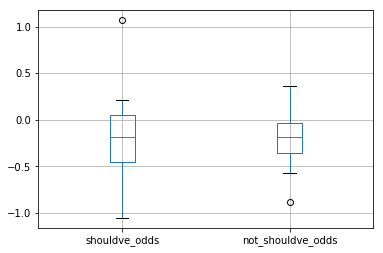

In [11]:
df.boxplot(column=['shouldve_odds', 'not_shouldve_odds'])

In [27]:
print(ttest_1samp(df['shouldve_odds'], 0))
for i, g in df.groupby('race'):
    print(i, ttest_1samp(g['shouldve_odds'], 0))

Ttest_1sampResult(statistic=-2.0879975088054836, pvalue=0.049797499455887545)
POC Ttest_1sampResult(statistic=-0.9294853187442579, pvalue=0.3768942932853042)
white Ttest_1sampResult(statistic=-2.3975649783673476, pvalue=0.0374712176170982)


# subjects & complements of modals

In [16]:
translator = str.maketrans('', '', string.punctuation)

In [33]:
def get_valid(l):
    prepend = []
    for t in l:
        tr = t.translate(translator)
        if t in ['have', 've', 'not', 't', '', ' ', 'to']:
            continue
        elif t in ['be', 'the', 'a']:
            prepend.append(t)
        elif len(prepend) > 0:
            return ' '.join(prepend) + ' ' + t.lower().translate(translator)
        else:
            return t.lower().translate(translator) 
    return ''

In [34]:
def log_odds(counts1, counts2, prior):
    # counts1 will be positive and counts2 will be negative
    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    n1 = sum(list(counts1.values()))
    n2 = sum(list(counts2.values()))
    nprior = sum(list(prior.values()))
    for word in prior.keys():
        if prior[word] == 0:
            delta[word] = 0
            continue
        l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
        l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
        sigmasquared[word] = 1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
        sigma[word] = math.sqrt(sigmasquared[word])
        delta[word] = (math.log(l1) - math.log(l2)) / sigma[word]
        #delta[word] = (math.log(l1) - math.log(l2))
    return delta

In [35]:
def get_contexts(tweets, m):
    context_words = []
    before = []
    after = []
    trigrams = []
    twoword = False
    if len(m.split()) > 1:
        modal_first = m.split()[0]
        twoword = True
    else:
        modal_first = m
    tweets['text'] = tweets['text'].astype(str).apply(clean_text, args=(True, None, False))
    for words in tweets['text']:
        trigram = []
        for i, w in enumerate(words):
            if twoword and w == modal_first and i < len(words)-1 and words[i+1] == 'to':
                context_words.extend(words[max(0, i-1):i+6])
                trigram = [m]
                break
            elif w.startswith(modal_first + 'n') or (len(words) > i+1 and words[i+1] == 'not'):
                context_words.extend(words[max(0, i-1):i+6])
                trigram = [m + ' not']
                break
            elif w.startswith(modal_first) and (w.endswith('ve') or (len(words) > i+1 and words[i+1] in ['have', 've'])):
                context_words.extend(words[max(0, i-1):i+6])
                trigram = [m + ' have']
                break
            elif not twoword and w.startswith(m):
                context_words.extend(words[max(0, i-1):i+5])
                trigram = [m]
                break
        bef = get_valid(reversed(words[:i]))
        aft = ''
        if i < len(words) -1:
            aft = get_valid(words[i+1:])
        trigram = [bef] + trigram + [aft]
        trigram = ' '.join(trigram)
        if bef != '':
            before.append(bef)
        if aft != '':
            if 'not ' in trigram:
                aft = 'not ' + aft
            after.append(aft)
        trigrams.append(trigram)
    return Counter(context_words), Counter(before), Counter(after), Counter(trigrams)

In [36]:
ic_modals = ['must', 'should']
c_modals = ['need to', 'needs to', 'have to', 'has to']
modals = ic_modals + c_modals
rep_modal_context = {m:[] for m in modals}
dem_modal_context = {m:[] for m in modals}
rep_modal_bef = {m:[] for m in modals}
dem_modal_bef = {m:[] for m in modals}
rep_modal_aft = {m:[] for m in modals}
dem_modal_aft = {m:[] for m in modals}
rep_modal_tri = {m:[] for m in modals}
dem_modal_tri = {m:[] for m in modals}

def add_vals(contains):
    dem, rep = split_party(contains)
    ctx, bef, aft, tri = get_contexts(dem, m)
    dem_modal_context[m].append(ctx)
    dem_modal_bef[m].append(bef)
    dem_modal_aft[m].append(aft)
    dem_modal_tri[m].append(tri)
    ctx, bef, aft, tri = get_contexts(rep, m)
    rep_modal_context[m].append(ctx)
    rep_modal_bef[m].append(bef)
    rep_modal_aft[m].append(aft)
    rep_modal_tri[m].append(tri)
    
for event in events:
    data = pd.read_csv(TWEET_DIR+event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'isRT', 'remove'])
    data = filter_retweets(data)
    #data =  data[~data['text'].str.contains(r'http|\.com|www', case=False)]  # add to filter URLs
    for m in ic_modals:
        contains = data[data['text'].str.contains(r'\b' + re.escape(m) + r"[n'’]?\w*\b", case=False)]
        add_vals(contains)
    for m in c_modals:
        contains = data[data['text'].str.contains(r'\b' + re.escape(m) + r"\b", case=False)]
        add_vals(contains)

/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [39]:
def get_most_partisan(dem_vals, rep_vals):
    most_rep = {m:[] for m in modals}
    most_dem = {m:[] for m in modals}
    for m in modals:
        for i, (d, r) in enumerate(zip(dem_vals[m], rep_vals[m])):
            if len(d) == 0 or len(r) == 0:
                continue
            odds = log_odds(d, r, d+r)
            most_rep[m].extend([k for k, v in odds.items() if v < -0.2])
            most_dem[m].extend([k for k, v in odds.items() if v > 0.2])
    for m in most_rep:
        most_rep[m] = Counter(most_rep[m]).most_common()
    for m in most_dem:
        most_dem[m] = Counter(most_dem[m]).most_common()
    return most_rep, most_dem

In [40]:
most_rep_ctx, most_dem_ctx = get_most_partisan(dem_modal_context, rep_modal_context)
most_rep_bef, most_dem_bef = get_most_partisan(dem_modal_bef, rep_modal_bef)
most_rep_aft, most_dem_aft = get_most_partisan(dem_modal_aft, rep_modal_aft)
most_rep_tri, most_dem_tri= get_most_partisan(dem_modal_tri, rep_modal_tri)

In [ ]:
def print_top(dem, rep):
    for m,  v in dem.items():
        print('\\begin{center}\\textbf{' + m.upper() + '}\\end{center}')
        toprint_dem = ''
        for k, count in v:
            if count > 3:
                toprint_dem += "%s (%d), " % (k, count)
        print('\\noindent\\emph{Democrat}\\\\' + toprint_dem[:-2].replace('#','\\#') + '\\\\')
        toprint_rep = ''
        for k, count in rep[m]:
            if count > 3:
                toprint_rep += "%s (%d), " % (k, count)
        print('\\noindent\\emph{Republican}\\\\' + toprint_rep[:-2].replace('#','\\#') + '\\\\')
    

In [75]:
print_top(most_dem_bef, most_rep_bef)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\we (16), congress (12), prayer (12), violenc (11), this (11), someth (10), i (10), mad (10), peopl (9), more (9), long (9), mani (9), can (9), action (9), insan (8), they (8), govern (8), all (8), it (8), and (8), gun (8), america (8), live (8), nra (8), time (7), he (7), who (7), whi (7), there (7), children (7), shoot (6), thing (6), chang (6), check (6), communiti (6), republican (6), is (6), epidem (6), famili (6), tragedi (6), blood (6), gunviol (6), now (6), issu (6), also (5), men (5), gop (5), state (5), but (5), law (5), kill (5), nation (5), politician (5), senat (5), guy (5), simpli (5), innoc (5), ppl (5), weapon (5), societi (5), even (5), carnag (5), rifl (5), heart (5), countri (5), shooter (4), american (4), media (4), that (4), world (4), govt (4), kid (4), yet (4), suspect (4), candid (4), sale (4), what (4), leader (4), somebodi (4), work (4), me (4), everyon (4), still (4), god (4), victim (4), hatr (

In [76]:
print_top(most_dem_aft, most_rep_aft)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\do (20), end (14), stop (12), be white (12), die (12), address (12), act (12), not enough (11), stand (10), all (10), we (10), find (10), come (9), be done (9), ask (9), get (9), chang (9), pass (9), say (8), rememb (8), be taken (8), happen (8), now (8), this (7), face (7), prevent (7), includ (7), be proud (7), vote (7), be veri (7), keep (7), be stop (7), go (7), read (7), see (7), gun (7), be so (7), continu (7), miss (7), also (6), not just (6), be hard (6), be chang (6), been (6), demand (6), live (6), be realli (6), take (6), not get (6), hold (6), fight (6), lead (6), call (6), be lost (6), final (6), follow (6), push (6), suffer (6), work (6), be feel (6), not forget (6), rise (6), honor (6), not becom (6), perish (5), answer (5), fuck (5), ensur (5), feel (5), think (5), fix (5), deal (5), i (5), realli (5), be some (5), mean (5), build (5), be someth (5), examin (5), up (5), make (5), understand (5), be mental

In [77]:
print_top(most_dem_tri, most_rep_tri)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\we must do (19), we must end (12), we must address (12), congress must act (10), this must stop (10), we must all (9), we must stop (9), someth must be done (9), mani must die (9), prayer must not enough (9), we must act (9), shooter must be white (8), we must stand (8), i must say (8), he must be white (8), violenc must end (8), long must we (8), more must die (8), this must end (8), we must find (8), mad must stop (8), violenc must stop (8), and must do (8), we must vote (8), insan must stop (7), it must stop (7), peopl must die (7), we must rememb (7), shoot must stop (7), we must keep (7), whi must we (7), we must fight (7), we must get (7), we must make (7), we must chang (7), we must continu (7), mad must end (7), time must this (6), we must prevent (6), someth must chang (6), we must demand (6), we must take (6), we must also (6), is must  (6), live must be lost (6), this must chang (6), kill must stop (6), we mus

In [41]:
print_top(most_dem_tri, most_rep_tri)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\we must do (19), we must end (12), we must address (12), congress must act (10), this must stop (10), we must all (9), we must stop (9), something must be done (9), many must die (9), prayers must not enough (9), we must act (9), shooter must be white (8), we must stand (8), i must say (8), he must be white (8), violence must end (8), long must we (8), more must die (8), this must end (8), we must find (8), madness must stop (8), violence must stop (8), killing must stop (8), and must do (8), we must vote (8), insanity must stop (7), it must stop (7), people must die (7), we must remember (7), we must keep (7), why must we (7), we must fight (7), we must get (7), we must make (7), we must change (7), we must continue (7), madness must end (7), times must this (6), we must prevent (6), something must change (6), we must demand (6), we must take (6), we must also (6), a is must  (6), shootings must end (6), lives must be l